,Week_Number,State,Cases
0,1,amazonas,0.0
1,1,antioquia,22.0
2,1,arauca,0.0
3,1,atlantico,4.0
4,1,bogota,0.0
...,...,...,...
1135,49,sucre,4.0
1136,49,tolima,0.0
1137,49,valledelcauca,5.0
1138,49,vaupes,0.0


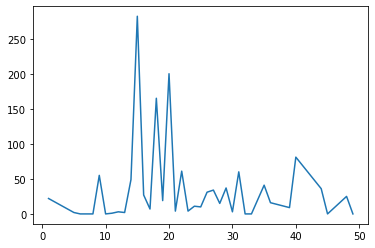

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

mu_df= pd.read_csv('data/colombia/Covid19_mu_preprocessed.csv')
mu_df.iloc[:, 1] = pd.to_datetime(mu_df.iloc[:, 1])
mu_df_m = mu_df.melt(id_vars=['Row_Num', 'Date'], 
              value_vars=['amazonas','antioquia','arauca','atlantico','bogota','bolivar','boyaca','caldas','caqueta','casanare','cesar','choco','cordoba','cundinamarca','guaviare ','huila','laguajira','magdalena','meta','narino','nortedesantander','quindio','risaralda','sanandres','santander','sucre','tolima','valledelcauca','vaupes','vichada'],
              var_name='State', value_name='Cases')
mu_df_m[mu_df_m['State'] == 'antioquia']
mu_df_m['Week_Number'] = mu_df_m['Date'].dt.isocalendar().week
co_mu_cases_df = mu_df_m.groupby(['Week_Number','State']).sum('Cases').drop('Row_Num', axis=1).reset_index()
antioquia_mu_cases_df = co_mu_cases_df[co_mu_cases_df['State'] == 'antioquia'] 
plt.plot(antioquia_mu_cases_df['Week_Number'], antioquia_mu_cases_df['Cases'])
co_mu_cases_df

In [11]:
co_mu_cases_df_past_week_df = co_mu_cases_df.copy() 
co_mu_cases_df_past_week_df["Week_Number"] = co_mu_cases_df["Week_Number"] + 1
co_mu_cases_df_past_week_df.rename(columns = {'Cases':'One_Week_Prior_Cases'}, inplace = True)

co_mu_cases_df_two_weeks_prior_df = co_mu_cases_df.copy() 
co_mu_cases_df_two_weeks_prior_df["Week_Number"] = co_mu_cases_df["Week_Number"] + 2
co_mu_cases_df_two_weeks_prior_df.rename(columns = {'Cases':'Two_Week_Prior_Cases'}, inplace = True)

co_mu_cases_df_three_weeks_prior_df = co_mu_cases_df.copy() 
co_mu_cases_df_three_weeks_prior_df["Week_Number"] = co_mu_cases_df["Week_Number"] + 3
co_mu_cases_df_three_weeks_prior_df.rename(columns = {'Cases':'Three_Week_Prior_Cases'}, inplace = True)

co_mu_cases_merged_df = co_mu_cases_df.merge(co_mu_cases_df_past_week_df[['One_Week_Prior_Cases',  'State', 'Week_Number']], how='left', left_on=['State', 'Week_Number'], right_on=['State', 'Week_Number'])
co_mu_cases_merged_df = co_mu_cases_merged_df.merge(co_mu_cases_df_two_weeks_prior_df[['Two_Week_Prior_Cases',  'State', 'Week_Number']], how='left', left_on=['State', 'Week_Number'], right_on=['State', 'Week_Number'])
co_mu_cases_merged_df = co_mu_cases_merged_df.merge(co_mu_cases_df_three_weeks_prior_df[['Three_Week_Prior_Cases',  'State', 'Week_Number']], how='left', left_on=['State', 'Week_Number'], right_on=['State', 'Week_Number'])
co_mu_cases_merged_df = co_mu_cases_merged_df.fillna(0)
states = {'amazonas':101,
'antioquia':102,
'arauca': 103,
'atlantico':104,
'bogota':105,
'bolivar':106,
'boyaca':107,
'caldas':108,
'caqueta':109,
'casanare':110,
'cesar':111,
'choco':112,
'cordoba':113,
'cundinamarca':114,
'guaviare ':115,
'huila':116,
'laguajira':117,
'magdalena':118,
'meta':119,
'narino':120,
'nortedesantander':121,
'quindio':122,
'risaralda':123,
'sanandres':124,
'santander':125,
'sucre':126,
'tolima':127,
'valledelcauca':128,
'vaupes':129,
'vichada':130}
co_mu_cases_merged_df['State_Code'] = co_mu_cases_merged_df['State'].map(states)
co_mu_cases_merged_df



,Week_Number,State,Cases,One_Week_Prior_Cases,Two_Week_Prior_Cases,Three_Week_Prior_Cases,State_Code
0,1,amazonas,0.0,0.0,0.0,0.0,101
1,1,antioquia,22.0,0.0,0.0,0.0,102
2,1,arauca,0.0,0.0,0.0,0.0,103
3,1,atlantico,4.0,0.0,0.0,0.0,104
4,1,bogota,0.0,0.0,0.0,0.0,105
...,...,...,...,...,...,...,...
1135,49,sucre,4.0,0.0,0.0,0.0,126
1136,49,tolima,0.0,2.0,0.0,0.0,127
1137,49,valledelcauca,5.0,1.0,0.0,0.0,128
1138,49,vaupes,0.0,0.0,0.0,0.0,129


In [ ]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold



min_week=co_mu_cases_merged_df['Week_Number'].min()
max_week=co_mu_cases_merged_df['Week_Number'].max()


num_weeks=int((max_week-min_week))

train_start_week = 28
train_end_week = train_start_week + 4

predict_start_week = train_end_week
predict_end_week = predict_start_week + 2

predicted_df_all_days = pd.DataFrame(columns=['Week_Number','State_code','Predicted_Weekly_Cases', 'Actual_Weekly_Cases'])

for week_num in range(num_weeks):
    if (predict_end_week > 42):
        break
    
    print("train:", train_start_week ,":", train_end_week, 
        " predict:" , predict_start_week, ":",  predict_end_week)
    train_week = pd.Series(range(train_start_week,train_end_week))
    #print ("training week series :" , train_week.array)
    X_train = co_mu_cases_merged_df[['Week_Number', 'State_Code', 'One_Week_Prior_Cases', 'Two_Week_Prior_Cases','Three_Week_Prior_Cases']].copy()
    X_train_week = X_train.loc[(X_train['Week_Number'].isin(train_week))]
    X_train_week =X_train_week.drop(['Week_Number'], axis=1)
    Weekly_Cases_Deaths = co_mu_cases_merged_df.loc[(co_mu_cases_merged_df['Week_Number'].isin(train_week))]['Cases']  
    predicted_df = pd.DataFrame(columns=['Week_Number','State_code','Predicted_Weekly_Cases', 'Actual_Weekly_Cases'])
    if len(Weekly_Cases_Deaths) > 0:
       
        X_train = X_train_week
        Y_train = Weekly_Cases_Deaths
        
        #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
        xgbReg = xgb.XGBRegressor()

        parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01, 0.05, 0.08], #so called `eta` value
              'max_depth': [1,2,3,4],
              'min_child_weight': [1,2],
              'subsample': [0.8],
              'colsample_bytree' : [0.8],
              'n_estimators': [ 100,200]}
        tscv = StratifiedKFold(n_splits=2, shuffle=False, random_state = None)
        xgb_grid = GridSearchCV(xgbReg,
                        parameters,
                        cv = tscv,
                        n_jobs = 4,
                        scoring = 'r2',
                        verbose=True)

        xgb_grid.fit(X_train,Y_train)


        print(xgb_grid.best_score_)
        print(xgb_grid.best_params_)
        results = xgb_grid.cv_results_
        predict_week = pd.Series(range(predict_start_week, predict_end_week))
        #print ("predicting next week series :" , predict_week.array)
        print(predict_week)
        X_predict = co_mu_cases_merged_df[['Week_Number', 'State_Code', 'One_Week_Prior_Cases', 'Two_Week_Prior_Cases','Three_Week_Prior_Cases']].copy()
        X_predict_week = X_predict.loc[(X_predict['Week_Number'].isin(predict_week))] 
        X_predict_week =X_predict_week.drop(['Week_Number'], axis=1)
        predict_week_df = co_mu_cases_merged_df.loc[(co_mu_cases_merged_df['Week_Number'].isin(predict_week))]
        Y_actual_predict_week = predict_week_df['Cases']
        #best_reg.fit(X_tune_week, Y_actual_tune_week)
        Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
        

        predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
        print(predict_score)

        predicted_df["State_Code"] = predict_week_df['State_Code']
        predicted_df["Week_Number"] = predict_week_df['Week_Number']
        
        predicted_df["Predicted_Weekly_Cases"] = Y_predict_week
        predicted_df["Actual_Weekly_Cases"] = Y_actual_predict_week
        #predicted_df.to_csv("data/predictions/predicted_us_deaths_" +  forecast_day + ".csv")                     
        predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])
        
        
    train_start_week = train_start_week + 2
    train_end_week = train_end_week + 2
    predict_start_week = train_end_week
    predict_end_week = predict_start_week + 2
predicted_df_all_days.to_csv("predicted_all_weeks_mu.csv", index=False)  
   
        

train: 28 : 32  predict: 32 : 34
Fitting 2 folds for each of 48 candidates, totalling 96 fits


/Users/snathikudi/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:   11.1s finished
/Users/snathikudi/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.13991518891850718
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
0    32
1    33
dtype: int64
-307.64772739658235
train: 30 : 34  predict: 34 : 36
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    9.3s finished
/Users/snathikudi/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.0008935956540994661
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
0    34
1    35
dtype: int64
-0.046802628983554806
train: 32 : 36  predict: 36 : 38
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    9.3s finished
/Users/snathikudi/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.10182056902438502
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
0    36
1    37
dtype: int64
-0.0857608968652448
train: 34 : 38  predict: 38 : 40
Fitting 2 folds for each of 48 candidates, totalling 96 fits
